In [38]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ebhhsaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
tweets_df = pd.read_csv('Datasets/trump_tweets.csv')
tweets_df.head(20)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,A GREAT DAY IN ARIZONA! https://t.co/jsohSb5QF6,06-24-2020 04:26:29,19259.0,87048,false,1.275646e+18
1,Twitter for iPhone,It is ashame that Congress doesn’t do somethin...,06-24-2020 03:49:10,27893.0,148055,false,1.275637e+18
2,Twitter for iPhone,Tomorrow @SenatorTimScott and the Senate Repub...,06-24-2020 03:30:26,14197.0,57121,false,1.275632e+18
3,Twitter for iPhone,BIG VICTORY for patients – Federal court UPHOL...,06-24-2020 01:21:21,41496.0,176760,false,1.275600e+18
4,Twitter for iPhone,RT @WhiteHouse: LIVE: POTUS delivers an addres...,06-23-2020 22:33:15,11124.0,0,true,1.275558e+18
5,Twitter for iPhone,RT @WhiteHouse: President @realDonaldTrump is ...,06-23-2020 19:32:26,10693.0,0,true,1.275512e+18
6,Twitter for iPhone,RT @TeamTrump: President @realDonaldTrump: We ...,06-23-2020 19:32:26,7327.0,0,true,1.275512e+18
7,Twitter for iPhone,RT @KellyannePolls: #SchoolChoice gives parent...,06-23-2020 19:31:56,8976.0,0,true,1.275512e+18
8,Twitter for iPhone,RT @TeamTrump: President @realDonaldTrump will...,06-23-2020 19:27:55,10241.0,0,true,1.275511e+18
9,Twitter for iPhone,RT @TeamTrump: Governor of Arizona Doug Ducey ...,06-23-2020 19:25:52,8238.0,0,true,1.275510e+18


In [27]:
def clean_tweets(df=tweets_df, tweet_col='text', date_col='created_at', start_datetime=datetime(2020,1,20, 0, 0, 0)):
    df_copy = df.copy()
    df_copy.dropna(inplace=True) # drop rows with empty values
    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S')) # format the date
    df_copy = df_copy[df_copy[date_col] >=start_datetime] # filter rows older than a given date
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower() # lower the tweets
    
    #filter out stop words and URLs
    en_stop_words = set(stopwords.words('english')) 
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }

    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word))]))

    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))

    return df_copy

  
df_tweets = pd.read_csv('Datasets/trump_tweets.csv')
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,preprocessed_text,tokenized_text
0,Twitter for iPhone,A GREAT DAY IN ARIZONA! https://t.co/jsohSb5QF6,2020-06-24 04:26:29,19259.0,87048,false,1.275646e+18,great day arizona!,"[great, day, arizona]"
1,Twitter for iPhone,It is ashame that Congress doesn’t do somethin...,2020-06-24 03:49:10,27893.0,148055,false,1.275637e+18,ashame congress doesn’t something lowlifes bur...,"[ashame, congress, doesn, something, lowlifes,..."
2,Twitter for iPhone,Tomorrow @SenatorTimScott and the Senate Repub...,2020-06-24 03:30:26,14197.0,57121,false,1.275632e+18,tomorrow @senatortimscott senate republicans g...,"[tomorrow, senatortimscott, senate, republican..."
3,Twitter for iPhone,BIG VICTORY for patients – Federal court UPHOL...,2020-06-24 01:21:21,41496.0,176760,false,1.275600e+18,big victory patients – federal court upholds h...,"[big, victory, patients, federal, court, uphol..."
4,Twitter for iPhone,RT @WhiteHouse: LIVE: POTUS delivers an addres...,2020-06-23 22:33:15,11124.0,0,true,1.275558e+18,@whitehouse: live: potus delivers address youn...,"[whitehouse, live, potus, delivers, address, y..."


In [30]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df_tweets_clean['preprocessed_text'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)
all_content_train[:10]

Number of texts processed:  5289


[TaggedDocument(words='great day arizona!', tags=[0]),
 TaggedDocument(words='ashame congress doesn’t something lowlifes burn american flag. stopped now!', tags=[1]),
 TaggedDocument(words='tomorrow @senatortimscott senate republicans great bill #justiceact vote. great people color police - fact major police support. rebuilding trust keeping communities safe! hope sign law asap!', tags=[2]),
 TaggedDocument(words='big victory patients – federal court upholds hospital price transparency. patients deserve know price care enter hospital. action will. may well bigger healthcare itself. congratulations america!', tags=[3]),
 TaggedDocument(words='@whitehouse: live: potus delivers address young americans', tags=[4]),
 TaggedDocument(words='@whitehouse: president @realdonaldtrump yuma arizona commemorate completion 200+ miles border wall!', tags=[5]),
 TaggedDocument(words='@teamtrump: president @realdonaldtrump: prevented coronavirus catastrophe southern border', tags=[6]),
 TaggedDocument(w

In [148]:
d2v_model = Doc2Vec(all_content_train, vector_size = 150, window = 5, min_count = 5, workers=4, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=20, start_alpha=0.002, end_alpha=-0.016)

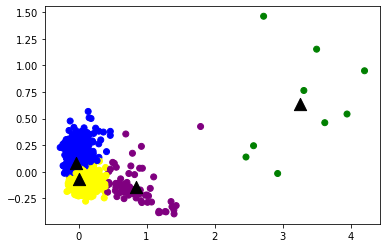

In [150]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [151]:
test_data = word_tokenize("@teamtrump: president @realdonaldtrump let thugs destroy america's monuments!".lower())
v1 = d2v_model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = d2v_model.docvecs.most_similar([v1])
print(similar_doc)

V1_infer [ 0.03370733  0.00766937  0.00039244  0.0172714  -0.01631867  0.02829066
  0.0531629   0.0198673   0.03109836 -0.04352343  0.00402605 -0.0209975
 -0.05329916  0.04456385 -0.04118071 -0.03429027 -0.03141353  0.00809093
  0.01973449 -0.00024705  0.03513158 -0.0118878   0.04917881 -0.0456365
 -0.01617965 -0.0858008   0.01240519  0.06562117 -0.03939807 -0.0015972
  0.0047583   0.01664645 -0.02249384  0.06237544 -0.02302963  0.01320981
  0.03052005  0.04745897 -0.02604763  0.03808212  0.0100408  -0.000431
 -0.01066963 -0.00847675  0.02409588 -0.01418656 -0.00544809 -0.00622782
 -0.00103002  0.00407305  0.01802056  0.04231489 -0.01106901  0.00456385
 -0.02747189  0.02546874 -0.04164609  0.01080411 -0.0244096   0.02218873
  0.01989003 -0.0133251   0.00522025 -0.01355156  0.02956985 -0.01873697
  0.07324331  0.01832699 -0.01893032  0.03337003  0.01662049 -0.03267612
 -0.02188531 -0.01295958  0.04444324 -0.00134445 -0.01686378 -0.06529494
  0.0036096  -0.01963969  0.0212881   0.0081892

In [152]:
dictionary = {}
for index in range(len(d2v_model.docvecs.vectors_docs)): 
    if l[index] in dictionary:
        value = []
        value = dictionary[l[index]]
        dictionary[l[index]] = value
    else:
        dictionary[l[index]]=d2v_model.docvecs.vectors_docs[index]
print(dictionary)

{0: array([-1.52454870e-02,  6.76446711e-04, -7.87149090e-03, -7.22992979e-03,
        1.53585440e-02, -5.67393471e-03, -1.55298654e-02, -4.68038395e-03,
       -1.51483575e-03,  4.44539404e-03, -2.57358281e-03, -2.58657988e-03,
        1.20260641e-02, -1.81175768e-02,  2.04876508e-03,  1.23497685e-02,
        8.62459186e-03, -5.04520535e-03, -1.17966975e-03,  4.01950581e-03,
       -9.61325876e-03,  6.83762785e-03, -3.72144044e-03,  1.23080444e-02,
        8.39371141e-03,  1.88982245e-02, -9.86979902e-03, -1.73750445e-02,
        7.76046375e-03, -3.42812948e-03, -3.44183203e-03, -1.22608710e-03,
       -1.86922634e-03, -1.56388804e-02,  4.47035767e-03,  9.98708187e-04,
       -1.72441006e-02, -7.38676265e-03,  1.25914710e-02, -4.66662180e-03,
        2.14244309e-03,  1.93965354e-03,  7.95962755e-03,  3.92316375e-04,
       -2.61612353e-04,  4.14961250e-04,  3.54439835e-03, -1.38699869e-03,
        2.56525673e-04, -4.54137422e-04, -1.81252807e-02, -6.26290403e-03,
        1.03197172e-0

In [153]:
[all_content_train[i] for i, label in enumerate(labels) if label == 0]

[TaggedDocument(words='great day arizona!', tags=[0]),
 TaggedDocument(words='ashame congress doesn’t something lowlifes burn american flag. stopped now!', tags=[1]),
 TaggedDocument(words='tomorrow @senatortimscott senate republicans great bill #justiceact vote. great people color police - fact major police support. rebuilding trust keeping communities safe! hope sign law asap!', tags=[2]),
 TaggedDocument(words='big victory patients – federal court upholds hospital price transparency. patients deserve know price care enter hospital. action will. may well bigger healthcare itself. congratulations america!', tags=[3]),
 TaggedDocument(words='@whitehouse: live: potus delivers address young americans', tags=[4]),
 TaggedDocument(words='@whitehouse: president @realdonaldtrump yuma arizona commemorate completion 200+ miles border wall!', tags=[5]),
 TaggedDocument(words='@teamtrump: president @realdonaldtrump: prevented coronavirus catastrophe southern border', tags=[6]),
 TaggedDocument(w